In [27]:
import json
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import inflect
import time
import gensim
import tqdm
engine = inflect.engine()

In [2]:
recipes = json.load(open('../generated/all_recipes_repr.json'))

In [3]:
len(recipes)

963396

In [4]:
def singularize(word):
    ingr = engine.singular_noun(word)
    return word if (not ingr) else ingr

def clean_ing_word(word) : return singularize(word).lower()

def clean_whole_ing(ing) : return " ".join([clean_ing_word(word) for word in ing.split(" ")])

Word2Vec training

In [5]:
start_time = time.time()
model = gensim.models.Word2Vec(recipes, min_count=2)

time_after_creation = time.time()
print("creation of model :", time_after_creation - start_time, "sec.")

model.train(recipes, total_examples=len(recipes), epochs=25)

time_after_training = time.time()
print("model training :", time_after_training - time_after_creation, "sec.")

model.save('../generated/food_embeddings.bin')

time_after_saving = time.time()
print("model saving :", time_after_saving - time_after_training, "sec.")

creation of model : 12.071560144424438 sec.
model training : 72.55276608467102 sec.
model saving : 0.014596700668334961 sec.


Results investigation

In [6]:
model.wv.most_similar("lamb")

/home/luke/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lean lamb', 0.8524610996246338),
 ('lamb shoulder', 0.786700963973999),
 ('lamb chop', 0.600494384765625),
 ('loin lamb', 0.5983527898788452),
 ('lamb shank', 0.5770151019096375),
 ('shoulder lamb chop', 0.5694438219070435),
 ('lamb rib chop', 0.5653693675994873),
 ('eggplant', 0.5652459859848022),
 ('mutton', 0.5396901965141296),
 ('lentil', 0.5243619084358215)]

We see that the adjectives are creating new ingredients. Given we are only interested in flavours associations, we should ignore them. Indeed, shredded mushrooms and dried mushrooms should have the same flavour. 

In [7]:
model.wv.similarity(w1="salt", w2="pepper")

-0.5058616

In [8]:
 model.most_similar(positive=['rice', 'tomato'], negative=['pasta'], topn=1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('long-grain rice', 0.4770057499408722)]

We now display the embeddings using TSNE as a dimensionality reduction method

In [25]:
food_manyd = model[model.wv.vocab]
food_2d = TSNE(n_components=2).fit_transform(food_manyd)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


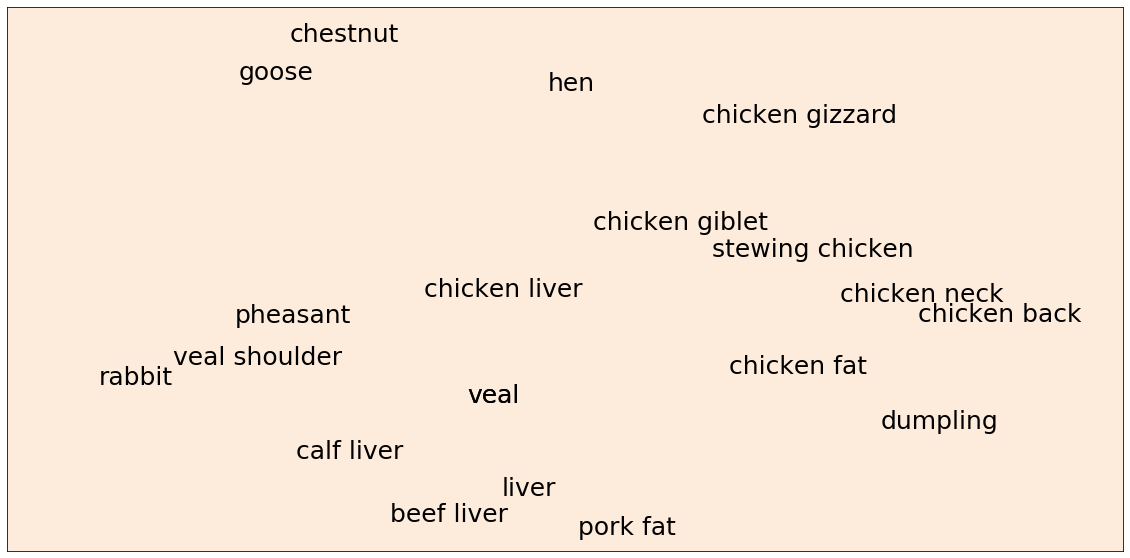

In [102]:
names_to_keep = ['veal']
vocab = list(model.wv.vocab)
epsilon = 0.1

for n in tqdm.tqdm_notebook(names_to_keep) :
    
    name_loc = food_2d[vocab.index(n)]
    to_plot = [name_loc]
    names = [n]
    
    for e, f in enumerate(food_2d) :
        dist = np.linalg.norm(f - name_loc)
        if (dist <= 4.5) :
            to_plot.append(f)
            names.append(vocab[e])
    
    to_plot = np.array(to_plot)
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({'font.size': 25})
    plt.figure()
    plt.scatter(to_plot[:, 0], to_plot[:, 1], color='#56af31', s=100, alpha=0)
    current_axis = plt.gca()
    current_axis.set_facecolor((float(253/255.0), float(235/255.0), float(220/255.0)))
    current_axis.axes.get_xaxis().set_visible(False)
    current_axis.axes.get_yaxis().set_visible(False)
    plt.xlim(-43, -31)
    
    
    for i, word in enumerate(names):
        if word == 'chicken back' :
            plt.annotate(word, xy=(to_plot[i, 0]+ 2*epsilon, to_plot[i, 1] - 2*epsilon ))
        else :
            plt.annotate(word, xy=(to_plot[i, 0] - 4*epsilon, to_plot[i, 1] - epsilon))

    plt.savefig("tsne_food.png")
    plt.show()